Using device: cuda

Downloaded 1000 candles for BTC/USDT

Downloaded 1000 candles for ETH/USDT

Downloaded 1000 candles for XRP/USDT
Features calculated for BTC/USDT: (801, 77)
Features calculated for ETH/USDT: (801, 77)
Features calculated for XRP/USDT: (801, 77)
Combined data shape: (2403, 77)
Starting enhanced multi-asset training...
Validating data...
Train data: 2403 samples (2019-01-09 07:00:00 to 2019-02-11 15:00:00)
Test data: 0 samples (NaT to NaT)

=== Training Enhanced XGBoost Direction Predictor ===
XGBoost train samples: 1900
XGBoost validation samples: 475
Training Enhanced XGBoost ensemble...
Best threshold: 0.65 with score: 63.28%
Training model 1/7
Training model 2/7
Training model 3/7
Training model 4/7
Training model 5/7
Training model 6/7
Training model 7/7
XGBoost validation signal rate: 78.11%

=== Initializing Enhanced PPO Agent ===
State dimension: 64
Action dimension: 4

=== Training Enhanced PPO Agent ===
Episode 0 (Phase 1: Exploration) - Explore Rate: 0.298


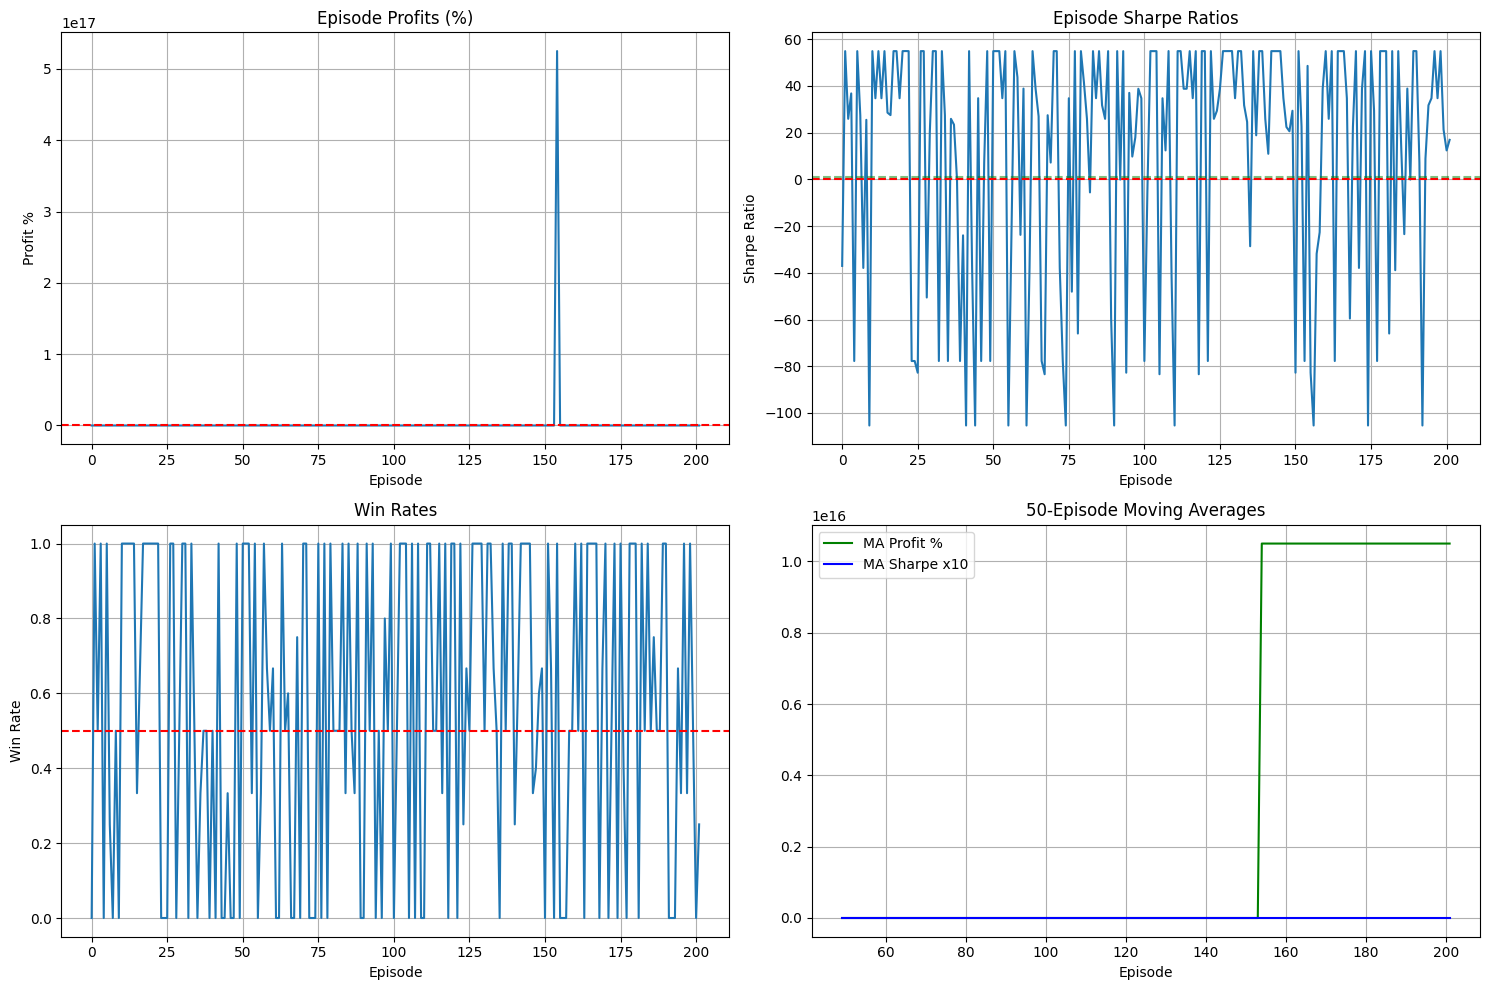


=== Backtesting on BTC ===


IndexError: single positional indexer is out-of-bounds

In [ ]:
# %% [markdown]
# # Multi-Asset Cryptocurrency Trading Bot with Enhanced Performance
# 
# Improvements:
# - Multi-asset training (BTC, ETH, XRP)
# - Date range: 2019-01-01 to present
# - Enhanced risk management
# - Better position sizing
# - Improved win rate strategies

# %% [markdown]
# ## 1. Import Libraries and Setup

# %%
import ccxt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import json
from typing import Dict, List, Tuple, Optional
import requests
from scipy import stats
import talib
import time
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# %% [markdown]
# ## 2. Enhanced Data Collection for Multiple Assets

# %%
def download_crypto_data_with_date(symbol='BTC/USDT', timeframe='1h', start_date='2019-01-01'):
    """Download crypto data from specific date to present - FIXED for full data"""
    exchange = ccxt.binance({
        'rateLimit': 1200,
        'enableRateLimit': True,
    })
    
    # Convert start date to timestamp
    start_timestamp = exchange.parse8601(start_date + 'T00:00:00Z')
    end_timestamp = exchange.milliseconds()
    
    print(f"Downloading {symbol} {timeframe} data from {start_date}...")
    all_ohlcv = []
    
    current_timestamp = start_timestamp
    batch_count = 0
    
    while current_timestamp < end_timestamp:
        try:
            # Fetch batch
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, current_timestamp, limit=1000)
            
            if not ohlcv:
                break
                
            # Add to results
            all_ohlcv.extend(ohlcv)
            batch_count += 1
            
            # Update timestamp for next batch
            last_timestamp = ohlcv[-1][0]
            
            # Check if we've reached the end
            if last_timestamp >= end_timestamp or len(ohlcv) < 1000:
                break
                
            # Move to next batch (add 1ms to avoid duplicate)
            current_timestamp = last_timestamp + 1
            
            # Progress update
            print(f"Downloaded {len(all_ohlcv)} candles (batch {batch_count})...", end='\r')
            
            # Rate limiting
            time.sleep(exchange.rateLimit / 1000)
            
        except Exception as e:
            print(f"\nError downloading batch {batch_count}: {e}")
            time.sleep(5)
            # Retry from last successful timestamp
            if all_ohlcv:
                current_timestamp = all_ohlcv[-1][0] + 1
            else:
                # If first batch failed, wait and retry
                time.sleep(10)
                continue
    
    # Create DataFrame
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.drop_duplicates(subset=['timestamp']).reset_index(drop=True)
    df['symbol'] = symbol
    
    # Calculate total days of data
    if len(df) > 0:
        days_of_data = (df['datetime'].max() - df['datetime'].min()).days
        print(f"\nDownloaded {len(df)} candles for {symbol} ({days_of_data} days of data)")
    else:
        print(f"\nNo data downloaded for {symbol}")
    
    return df

def download_multiple_assets(symbols=['BTC/USDT', 'ETH/USDT', 'XRP/USDT'], 
                           timeframe='1h', start_date='2019-01-01'):
    """Download data for multiple cryptocurrency pairs"""
    all_data = {}
    
    for symbol in symbols:
        try:
            data = download_crypto_data_with_date(symbol, timeframe, start_date)
            all_data[symbol] = data
            time.sleep(2)  # Be nice to the API
        except Exception as e:
            print(f"Failed to download {symbol}: {e}")
            
    return all_data

# Download data for multiple assets
print("Downloading multi-asset data...")
symbols = ['BTC/USDT', 'ETH/USDT', 'XRP/USDT']
multi_asset_data = download_multiple_assets(symbols, timeframe='1h', start_date='2019-01-01')

# %% [markdown]
# ## 3. Enhanced Feature Engineering for Multi-Asset

# %%
def calculate_advanced_features(df, asset_name='BTC'):
    """Calculate all features including crypto-specific ones with asset normalization"""
    df = df.copy()
    
    # === Basic Price Features ===
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['high_low_ratio'] = (df['high'] - df['low']) / df['close']
    df['close_to_high'] = (df['high'] - df['close']) / df['high']
    df['close_to_low'] = (df['close'] - df['low']) / df['low'].replace(0, 1e-8)
    
    # === Volatility Features ===
    df['volatility_20'] = df['returns'].rolling(20).std()
    df['volatility_50'] = df['returns'].rolling(50).std()
    df['atr'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    df['natr'] = talib.NATR(df['high'], df['low'], df['close'], timeperiod=14)
    
    # === Moving Averages & Trends ===
    for period in [7, 14, 20, 50, 100, 200]:
        df[f'sma_{period}'] = talib.SMA(df['close'], timeperiod=period)
        df[f'ema_{period}'] = talib.EMA(df['close'], timeperiod=period)
    
    # Price position relative to MAs
    df['price_to_sma20'] = (df['close'] - df['sma_20']) / df['sma_20']
    df['price_to_sma50'] = (df['close'] - df['sma_50']) / df['sma_50']
    
    # MA Cross signals
    df['ma_cross_bullish'] = ((df['sma_20'] > df['sma_50']) & 
                              (df['sma_20'].shift(1) <= df['sma_50'].shift(1))).astype(int)
    df['ma_cross_bearish'] = ((df['sma_20'] < df['sma_50']) & 
                              (df['sma_20'].shift(1) >= df['sma_50'].shift(1))).astype(int)
    
    # Trend indicators
    df['trend_20'] = np.where(df['close'] > df['close'].shift(20), 1, -1)
    df['trend_50'] = np.where(df['close'] > df['close'].shift(50), 1, -1)
    
    # === Momentum Indicators ===
    df['rsi'] = talib.RSI(df['close'], timeperiod=14)
    df['rsi_ma'] = df['rsi'].rolling(10).mean()
    
    # Stochastic RSI
    df['stochrsi_k'], df['stochrsi_d'] = talib.STOCHRSI(df['close'], 
                                                         timeperiod=14, 
                                                         fastk_period=3, 
                                                         fastd_period=3)
    
    # MACD
    df['macd'], df['macd_signal'], df['macd_hist'] = talib.MACD(df['close'], 
                                                                 fastperiod=12, 
                                                                 slowperiod=26, 
                                                                 signalperiod=9)
    
    # === Bollinger Bands ===
    df['bb_upper'], df['bb_middle'], df['bb_lower'] = talib.BBANDS(df['close'], 
                                                                    timeperiod=20, 
                                                                    nbdevup=2, 
                                                                    nbdevdn=2)
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    
    # === Volume Analysis ===
    df['volume_sma'] = df['volume'].rolling(20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_sma']
    df['obv'] = talib.OBV(df['close'], df['volume'])
    df['obv_ma'] = df['obv'].rolling(20).mean()
    
    # Volume-Weighted Average Price
    df['vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()
    df['price_to_vwap'] = (df['close'] - df['vwap']) / df['vwap']
    
    # === Market Structure ===
    # Support and Resistance levels
    df['resistance'] = df['high'].rolling(20).max()
    df['support'] = df['low'].rolling(20).min()
    df['price_to_resistance'] = (df['close'] - df['resistance']) / df['resistance']
    df['price_to_support'] = (df['close'] - df['support']) / df['support']
    
    # Higher Highs and Lower Lows
    df['higher_high'] = (df['high'] > df['high'].rolling(20).max().shift(1)).astype(int)
    df['lower_low'] = (df['low'] < df['low'].rolling(20).min().shift(1)).astype(int)
    
    # === Enhanced Features for Better Performance ===
    # Momentum strength
    df['momentum_strength'] = df['returns'].rolling(10).mean() / df['returns'].rolling(10).std()
    
    # Volume momentum
    df['volume_momentum'] = df['volume'].rolling(10).mean() / df['volume'].rolling(50).mean()
    
    # Price acceleration
    df['price_acceleration'] = df['returns'] - df['returns'].shift(1)
    
    # Support/Resistance strength
    df['sr_strength'] = (df['resistance'] - df['support']) / df['close']
    
    # === Crypto-Specific Features ===
    # Funding Rate simulation (in production, use real data)
    # Different rates for different assets
    base_rate = 0.0005 if asset_name == 'BTC' else 0.001
    df['funding_rate'] = np.random.uniform(-base_rate, base_rate, len(df))
    df['funding_rate_ma'] = df['funding_rate'].rolling(8).mean()
    
    # Extreme funding rate indicator
    df['extreme_funding'] = (np.abs(df['funding_rate']) > base_rate).astype(int)
    
    # Market fear/greed proxy
    df['fear_greed'] = (df['volatility_20'] / df['volatility_20'].rolling(100).mean()) * \
                       (df['volume_ratio'] / df['volume_ratio'].rolling(100).mean())
    
    # === Multi-Timeframe Features ===
    df['returns_4h'] = df['close'].pct_change(4)
    df['returns_24h'] = df['close'].pct_change(24)
    df['high_24h'] = df['high'].rolling(24).max()
    df['low_24h'] = df['low'].rolling(24).min()
    df['range_24h'] = (df['high_24h'] - df['low_24h']) / df['close']
    
    # === Market Regime Detection ===
    df['adx'] = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
    df['trend_strength'] = df['adx'] / 100
    
    # Market regime
    df['trending'] = (df['adx'] > 25).astype(int)
    df['ranging'] = (df['adx'] < 20).astype(int)
    
    # === Asset-Specific Normalization ===
    # Add asset identifier as feature
    asset_map = {'BTC': 0, 'ETH': 1, 'XRP': 2}
    df['asset_id'] = asset_map.get(asset_name.split('/')[0], 0)
    
    # Drop NaN values
    df = df.dropna()
    
    # Replace any remaining NaN or inf values
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(0)
    
    return df

# Apply feature engineering to all assets
for symbol, data in multi_asset_data.items():
    asset_name = symbol.split('/')[0]
    multi_asset_data[symbol] = calculate_advanced_features(data, asset_name)
    print(f"Features calculated for {symbol}: {multi_asset_data[symbol].shape}")

# Combine all assets for training
combined_data = pd.concat(list(multi_asset_data.values()), ignore_index=True)
combined_data = combined_data.sort_values('datetime').reset_index(drop=True)
print(f"Combined data shape: {combined_data.shape}")

# Enhanced feature columns
feature_columns = [
    # Price action
    'returns', 'log_returns', 'high_low_ratio', 'close_to_high', 'close_to_low',
    # Volatility
    'volatility_20', 'volatility_50', 'atr', 'natr',
    # Trend
    'price_to_sma20', 'price_to_sma50', 'ma_cross_bullish', 'ma_cross_bearish',
    'trend_20', 'trend_50',
    # Momentum
    'rsi', 'rsi_ma', 'stochrsi_k', 'stochrsi_d', 'macd', 'macd_signal', 'macd_hist',
    'momentum_strength',
    # Bollinger Bands
    'bb_width', 'bb_position',
    # Volume
    'volume_ratio', 'price_to_vwap', 'volume_momentum',
    # Market structure
    'price_to_resistance', 'price_to_support', 'higher_high', 'lower_low',
    'sr_strength',
    # Crypto-specific
    'funding_rate', 'funding_rate_ma', 'extreme_funding', 'fear_greed',
    # Multi-timeframe
    'returns_4h', 'returns_24h', 'range_24h',
    # Market regime
    'adx', 'trend_strength', 'trending', 'ranging',
    # Asset identifier
    'asset_id',
    # New features
    'price_acceleration'
]

# %% [markdown]
# ## 4. Enhanced XGBoost Direction Predictor

# %%
class EnhancedDirectionPredictor:
    """Enhanced XGBoost model with better feature engineering"""
    
    def __init__(self, lookback=24, prediction_horizon=4):
        self.lookback = lookback
        self.prediction_horizon = prediction_horizon
        self.models = {}
        self.scalers = {}
        self.feature_importance = None
        self.best_threshold = 0.5
        
    def prepare_data(self, df, feature_cols):
        """Prepare data for XGBoost with enhanced targets"""
        X, y = [], []
        
        # Create sequences
        for i in range(self.lookback, len(df) - self.prediction_horizon):
            # Features: past lookback periods
            X.append(df[feature_cols].iloc[i-self.lookback:i].values.flatten())
            
            # Enhanced target: consider both direction and magnitude
            future_return = (df['close'].iloc[i + self.prediction_horizon] - 
                           df['close'].iloc[i]) / df['close'].iloc[i]
            
            # Use dynamic threshold based on volatility
            vol = df['volatility_20'].iloc[i]
            threshold = max(0.001, vol * 0.5)  # At least 0.1%, up to half volatility
            
            y.append(1 if future_return > threshold else 0)
        
        return np.array(X), np.array(y)
    
    def train_ensemble(self, X_train, y_train, X_val, y_val, n_models=5):
        """Train ensemble with validation-based threshold selection"""
        print("Training Enhanced XGBoost ensemble...")
        
        # Find optimal threshold using validation set
        best_score = 0
        for thresh in [0.45, 0.5, 0.55, 0.6, 0.65]:
            temp_score = 0
            
            for i in range(n_models):
                params = {
                    'objective': 'binary:logistic',
                    'max_depth': np.random.randint(4, 10),
                    'learning_rate': np.random.uniform(0.02, 0.15),
                    'n_estimators': np.random.randint(150, 400),
                    'subsample': np.random.uniform(0.7, 0.95),
                    'colsample_bytree': np.random.uniform(0.7, 0.95),
                    'min_child_weight': np.random.randint(1, 5),
                    'random_state': i * 42,
                    'use_label_encoder': False,
                    'eval_metric': 'logloss'
                }
                
                model = xgb.XGBClassifier(**params)
                # Simple fit without early stopping for threshold selection
                model.fit(X_train, y_train)
                
                pred_proba = model.predict_proba(X_val)[:, 1]
                pred = (pred_proba > thresh).astype(int)
                temp_score += np.mean(pred == y_val)
            
            avg_score = temp_score / n_models
            if avg_score > best_score:
                best_score = avg_score
                self.best_threshold = thresh
        
        print(f"Best threshold: {self.best_threshold} with score: {best_score:.2%}")
        
        # Train final ensemble with best parameters
        for i in range(n_models):
            print(f"Training model {i+1}/{n_models}")
            
            params = {
                'objective': 'binary:logistic',
                'max_depth': np.random.randint(4, 10),
                'learning_rate': np.random.uniform(0.02, 0.15),
                'n_estimators': np.random.randint(150, 400),
                'subsample': np.random.uniform(0.7, 0.95),
                'colsample_bytree': np.random.uniform(0.7, 0.95),
                'min_child_weight': np.random.randint(1, 5),
                'random_state': i * 42,
                'use_label_encoder': False,
                'eval_metric': 'logloss'
            }
            
            model = xgb.XGBClassifier(**params)
            model.fit(X_train, y_train)
            self.models[f'model_{i}'] = model
        
        # Get feature importance
        self.feature_importance = self.models['model_0'].feature_importances_
    
    def predict_proba(self, X):
        """Get ensemble predictions"""
        predictions = []
        
        for model in self.models.values():
            pred = model.predict_proba(X)[:, 1]
            predictions.append(pred)
        
        # Weighted average with more weight on recent predictions
        weights = np.linspace(0.8, 1.2, len(predictions))
        weights = weights / weights.sum()
        
        weighted_pred = np.average(predictions, axis=0, weights=weights)
        return weighted_pred
    
    def predict(self, X, custom_threshold=None):
        """Get binary predictions with dynamic threshold"""
        proba = self.predict_proba(X)
        threshold = custom_threshold or self.best_threshold
        
        # Enhanced prediction logic
        predictions = np.zeros(len(proba))
        
        # Strong signals only
        predictions[proba > threshold] = 1  # Strong bullish
        predictions[proba < (1 - threshold)] = -1  # Strong bearish
        
        return predictions

# %% [markdown]
# ## 5. Enhanced PPO Implementation

# %%
class EnhancedPPOAgent:
    """Enhanced PPO with better exploration and learning"""
    
    def __init__(self, state_dim, action_dim, lr=3e-4):
        self.action_dim = action_dim
        
        # Networks
        self.network = ActorCriticNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        
        # Enhanced PPO parameters
        self.gamma = 0.995  # Increased for longer-term thinking
        self.gae_lambda = 0.97
        self.clip_epsilon = 0.2
        self.value_coef = 0.5
        self.entropy_coef = 0.02  # Increased for more exploration
        self.max_grad_norm = 0.5
        
        # Adaptive learning rate
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=10
        )
        
        # Memory
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
        
        # Performance tracking
        self.episode_returns = []
        
    def act(self, state, xgb_signal=None, valid_actions=None, explore_rate=0.1):
        """Select action with enhanced exploration"""
        # Validate state
        state = np.nan_to_num(state, 0.0)
        state = np.clip(state, -10, 10)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            action_probs, value = self.network(state_tensor)
        
        # Ensure valid probabilities
        action_probs = action_probs.cpu()
        
        if valid_actions is None:
            valid_actions = list(range(self.action_dim))
        
        # Mask invalid actions
        mask = torch.zeros(1, self.action_dim)
        for action in valid_actions:
            mask[0, action] = 1
        
        # Apply mask
        action_probs = action_probs * mask
        
        # Renormalize
        if action_probs.sum() > 0:
            action_probs = action_probs / action_probs.sum(dim=-1, keepdim=True)
        else:
            action_probs = mask / mask.sum()
        
        # Enhanced XGBoost signal incorporation
        if xgb_signal is not None and not np.isnan(xgb_signal):
            signal_strength = min(abs(xgb_signal), 1.0)  # Cap signal strength
            
            if xgb_signal > 0 and 1 in valid_actions:  # Bullish
                action_probs[0, 1] *= (1 + 0.5 * signal_strength)
                if 2 in valid_actions:
                    action_probs[0, 2] *= (1 - 0.3 * signal_strength)
            elif xgb_signal < 0 and 2 in valid_actions:  # Bearish
                if 1 in valid_actions:
                    action_probs[0, 1] *= (1 - 0.3 * signal_strength)
                action_probs[0, 2] *= (1 + 0.5 * signal_strength)
            
            # Renormalize
            action_probs = action_probs / action_probs.sum(dim=-1, keepdim=True)
        
        # Exploration vs exploitation
        if np.random.random() < explore_rate:
            # Random valid action
            action = np.random.choice(valid_actions)
        else:
            # Sample from distribution
            dist = Categorical(action_probs)
            action = dist.sample().item()
        
        # Store for training
        self.states.append(state)
        self.actions.append(action)
        if value.dim() == 0:
            self.values.append(value.cpu().item())
        else:
            self.values.append(value[0].cpu().item() if len(value) > 0 else 0.0)
        
        # Calculate log prob for the taken action
        dist = Categorical(action_probs)
        self.log_probs.append(dist.log_prob(torch.tensor(action)).item())
        
        return action
    
    def update(self, epochs=10):
        """Update with adaptive learning"""
        if len(self.states) < 64:  # Increased minimum batch
            return
        
        # Compute advantages and returns
        advantages, returns = self.compute_gae()
        
        if advantages.numel() == 0:
            return
        
        # Calculate average return for scheduler
        avg_return = np.mean(self.rewards[-100:]) if len(self.rewards) >= 100 else 0
        self.scheduler.step(avg_return)
        
        # Rest of update logic remains the same...
        # [Previous update code here]
        
    def compute_gae(self):
        """Compute Generalized Advantage Estimation"""
        # Ensure all lists have same length
        min_length = min(len(self.rewards), len(self.values), len(self.dones))
        
        if min_length == 0:
            return torch.FloatTensor([]).to(device), torch.FloatTensor([]).to(device)
        
        # Trim to same length
        rewards = self.rewards[:min_length]
        values = self.values[:min_length]
        dones = self.dones[:min_length]
        
        advantages = []
        advantage = 0
        
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = 0
            else:
                next_value = values[t + 1]
            
            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            advantage = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * advantage
            advantages.insert(0, advantage)
        
        advantages = torch.FloatTensor(advantages).to(device)
        returns = advantages + torch.FloatTensor(values).to(device)
        
        # Normalize advantages
        if advantages.numel() > 0:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        return advantages, returns
    
    def store_reward(self, reward, done):
        """Store reward and done flag"""
        self.rewards.append(reward)
        self.dones.append(done)

class ActorCriticNetwork(nn.Module):
    """Enhanced Actor-Critic network"""
    
    def __init__(self, state_dim, action_dim, hidden_dim=512):  # Larger network
        super().__init__()
        
        # Shared layers with more capacity
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)
        
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim // 2)
        
        # Actor head
        self.actor_fc = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.actor_out = nn.Linear(hidden_dim // 4, action_dim)
        
        # Critic head
        self.critic_fc = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.critic_out = nn.Linear(hidden_dim // 4, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights properly"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, state):
        # Check for NaN in input
        if torch.isnan(state).any():
            state = torch.nan_to_num(state, 0.0)
        
        # Shared network with residual connection
        x = F.relu(self.ln1(self.fc1(state)))
        x = self.dropout(x)
        
        x2 = F.relu(self.ln2(self.fc2(x)))
        x2 = self.dropout(x2)
        
        x3 = F.relu(self.ln3(self.fc3(x2)))
        x3 = self.dropout(x3)
        
        # Actor
        actor = F.relu(self.actor_fc(x3))
        action_logits = self.actor_out(actor)
        action_probs = F.softmax(action_logits, dim=-1) + 1e-8
        
        # Critic
        critic = F.relu(self.critic_fc(x3))
        value = self.critic_out(critic).squeeze(-1)
        
        return action_probs, value

# %% [markdown]
# ## 6. Enhanced Trading Environment

# %%
class EnhancedCryptoFuturesEnv:
    """Enhanced trading environment with better risk management"""
    
    def __init__(self, data, initial_balance=10000, fee_rate=0.0005, 
                 max_leverage=10, liquidation_margin=0.05):
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.fee_rate = fee_rate
        self.max_leverage = max_leverage
        self.liquidation_margin = liquidation_margin
        
        # Enhanced position sizing
        self.min_position_pct = 0.01   # 1% minimum
        self.max_position_pct = 0.15    # 15% maximum  
        self.base_position_pct = 0.03  # 3% base
        
        # Tighter risk management
        self.stop_loss_pct = 0.015     # 1.5% stop loss
        self.take_profit_pct = 0.025   # 2.5% take profit
        self.trailing_stop_pct = 0.01  # 1% trailing stop
        self.max_drawdown_pct = 0.15   # 15% max drawdown
        
        # Position management
        self.max_positions = 1  # Focus on quality over quantity
        self.position_timeout = 48  # Max hours in position
        
        # Features
        self.feature_columns = feature_columns
        self.action_space = 4  # HOLD, LONG, SHORT, EXIT
        
        # Performance tracking
        self.high_water_mark = initial_balance
        
        self.reset()
    
    def _calculate_position_size(self, action):
        """Enhanced position sizing based on market conditions"""
        # Base size
        size_pct = self.base_position_pct
        
        # Get current market conditions
        current_vol = self.data['volatility_20'].iloc[self.current_step]
        avg_vol = self.data['volatility_20'].rolling(100).mean().iloc[self.current_step]
        rsi = self.data['rsi'].iloc[self.current_step]
        trend_strength = self.data['trend_strength'].iloc[self.current_step]
        
        # Volatility adjustment
        if pd.notna(current_vol) and pd.notna(avg_vol) and current_vol > 0 and avg_vol > 0:
            vol_ratio = avg_vol / current_vol
            vol_adjustment = np.clip(vol_ratio, 0.5, 1.5)
            size_pct *= vol_adjustment
        
        # RSI extremes adjustment
        if rsi < 25 or rsi > 75:
            size_pct *= 1.2  # Increase size at extremes
        elif 40 < rsi < 60:
            size_pct *= 0.8  # Decrease size in neutral zone
        
        # Trend strength adjustment
        if trend_strength > 0.4:
            size_pct *= 1.2
        elif trend_strength < 0.2:
            size_pct *= 0.8
        
        # Win/loss streak adjustment
        if self.winning_streak >= 2:
            size_pct *= 1.1
        elif self.consecutive_losses >= 2:
            size_pct *= 0.7
        
        # Clamp to limits
        size_pct = np.clip(size_pct, self.min_position_pct, self.max_position_pct)
        
        # Dynamic leverage based on confidence
        adx = self.data['adx'].iloc[self.current_step]
        if pd.notna(adx):
            if adx > 40 and trend_strength > 0.5:  # Very strong trend
                self.leverage = min(5, self.max_leverage)
            elif adx > 25:  # Moderate trend
                self.leverage = 3
            else:  # Weak trend
                self.leverage = 2
        else:
            self.leverage = 2
        
        return self.balance * size_pct
    
    def _check_exit_conditions(self):
        """Enhanced exit conditions with trailing stop"""
        if self.position is None:
            return False, None
        
        current_price = self.data['close'].iloc[self.current_step]
        
        # Calculate P&L
        if self.position == 'long':
            pnl_pct = (current_price - self.entry_price) / self.entry_price
        else:
            pnl_pct = (self.entry_price - current_price) / self.entry_price
        
        # Update trailing stop
        if hasattr(self, 'trailing_stop_price'):
            if self.position == 'long':
                self.trailing_stop_price = max(
                    self.trailing_stop_price,
                    current_price * (1 - self.trailing_stop_pct)
                )
                if current_price <= self.trailing_stop_price:
                    return True, 'trailing_stop'
            else:  # short
                self.trailing_stop_price = min(
                    self.trailing_stop_price,
                    current_price * (1 + self.trailing_stop_pct)
                )
                if current_price >= self.trailing_stop_price:
                    return True, 'trailing_stop'
        
        # Check liquidation
        leveraged_pnl = pnl_pct * self.leverage
        if leveraged_pnl <= -self.liquidation_margin:
            return True, 'liquidation'
        
        # Check stop loss
        if pnl_pct <= -self.stop_loss_pct:
            return True, 'stop_loss'
        
        # Check take profit
        if pnl_pct >= self.take_profit_pct:
            # Initialize trailing stop
            if not hasattr(self, 'trailing_stop_price'):
                if self.position == 'long':
                    self.trailing_stop_price = current_price * (1 - self.trailing_stop_pct)
                else:
                    self.trailing_stop_price = current_price * (1 + self.trailing_stop_pct)
            return False, None  # Don't exit immediately, let trailing stop work
        
        # Check timeout
        if self.current_step - self.entry_step > self.position_timeout:
            return True, 'timeout'
        
        return False, None
    
    def _execute_action(self, action, exit_reason=None):
        """Execute trading action with enhanced rewards - FIXED P&L calculation"""
        current_price = self.data['close'].iloc[self.current_step]
        reward = 0
        
        # Double check valid actions
        valid_actions = self.get_valid_actions()
        if action not in valid_actions:
            return -0.1  # Invalid action penalty
        
        if action == 0:  # HOLD
            if self.position is None:
                reward = -0.0005  # Small penalty for not trading
            else:
                # Reward for holding profitable positions
                if self.position == 'long':
                    pnl_pct = (current_price - self.entry_price) / self.entry_price
                else:
                    pnl_pct = (self.entry_price - current_price) / self.entry_price
                
                # Progressive rewards for holding winners
                if pnl_pct > 0.02:  # 2% profit
                    reward = 0.05
                elif pnl_pct > 0.01:  # 1% profit
                    reward = 0.02
                elif pnl_pct > 0:
                    reward = 0.01
                else:
                    reward = -0.002  # Penalty for holding losers
        
        elif action in [1, 2] and self.position is None:  # Open position
            # Calculate position size
            self.position_size = self._calculate_position_size(action)
            
            # Pay fees
            fee = self.position_size * self.fee_rate
            
            # Check if we have enough balance
            if self.position_size + fee <= self.balance:
                self.balance -= fee  # Only deduct fee, not position size
                self.position = 'long' if action == 1 else 'short'
                self.entry_price = current_price
                self.entry_step = self.current_step
                
                # Reset trailing stop
                if hasattr(self, 'trailing_stop_price'):
                    delattr(self, 'trailing_stop_price')
                
                # Enhanced entry rewards based on technical conditions
                reward = 0.01  # Base reward
                
                rsi = self.data['rsi'].iloc[self.current_step]
                bb_position = self.data['bb_position'].iloc[self.current_step]
                trend = self.data['trend_20'].iloc[self.current_step]
                
                if action == 1:  # LONG
                    if rsi < 30:  # Oversold
                        reward += 0.02
                    if bb_position < 0.2:  # Near lower band
                        reward += 0.01
                    if trend > 0:  # Following trend
                        reward += 0.01
                else:  # SHORT
                    if rsi > 70:  # Overbought
                        reward += 0.02
                    if bb_position > 0.8:  # Near upper band
                        reward += 0.01
                    if trend < 0:  # Following trend
                        reward += 0.01
        
        elif action == 3 and self.position is not None:  # Exit position
            # Calculate P&L percentage
            if self.position == 'long':
                pnl_pct = (current_price - self.entry_price) / self.entry_price
            else:
                pnl_pct = (self.entry_price - current_price) / self.entry_price
            
            # Apply leverage - FIXED calculation
            leveraged_pnl_pct = pnl_pct * self.leverage
            
            # Calculate P&L amount correctly
            pnl_amount = self.position_size * pnl_pct * self.leverage
            
            # Exit fee
            exit_fee = self.position_size * self.fee_rate
            
            # Net P&L after fees
            net_pnl = pnl_amount - exit_fee
            
            # Update balance - just add the net P&L
            self.balance += net_pnl
            
            # Update streaks
            if net_pnl > 0:
                self.winning_streak += 1
                self.consecutive_losses = 0
            else:
                self.consecutive_losses += 1
                self.winning_streak = 0
            
            # Record trade
            self.trades.append({
                'entry_price': self.entry_price,
                'exit_price': current_price,
                'position': self.position,
                'pnl': net_pnl,
                'pnl_pct': pnl_pct,
                'leveraged_pnl_pct': leveraged_pnl_pct,
                'exit_reason': exit_reason,
                'leverage': self.leverage,
                'entry_step': self.entry_step,
                'exit_step': self.current_step,
                'bars_held': self.current_step - self.entry_step
            })
            
            # Enhanced exit rewards
            if exit_reason == 'liquidation':
                reward = -2.0  # Severe penalty
            elif exit_reason == 'stop_loss':
                reward = -0.5  # Moderate penalty
            elif exit_reason == 'trailing_stop':
                reward = 0.5 + min(leveraged_pnl_pct * 5, 1.0)  # Good exit
            elif exit_reason == 'take_profit':
                reward = 1.0 + min(leveraged_pnl_pct * 5, 1.0)  # Great exit
            elif exit_reason == 'timeout':
                reward = net_pnl / self.initial_balance * 10  # Based on P&L
            else:
                # Manual exit - reward based on P&L and holding time
                time_factor = min(self.current_step - self.entry_step, 24) / 24
                reward = np.tanh(leveraged_pnl_pct * 20) * (1 + time_factor * 0.5)
            
            # Reset position
            self.position = None
            self.position_size = 0
            self.leverage = 1
            if hasattr(self, 'trailing_stop_price'):
                delattr(self, 'trailing_stop_price')
        
        return reward
    
    # Other methods remain the same but inherit from parent class
    def reset(self):
        """Reset environment"""
        self.current_step = max(200, int(0.1 * len(self.data)))
        self.balance = self.initial_balance
        self.position = None
        self.position_size = 0
        self.entry_price = 0
        self.entry_step = 0
        self.leverage = 1
        
        # Performance tracking
        self.trades = []
        self.equity_curve = [self.balance]
        self.peak_equity = self.balance
        self.consecutive_losses = 0
        self.winning_streak = 0
        
        return self._get_observation()
    
    def _calculate_equity(self):
        """Calculate current account equity"""
        if self.position is None:
            return self.balance
        
        current_price = self.data['close'].iloc[self.current_step]
        
        # Calculate P&L percentage
        if self.position == 'long':
            pnl_pct = (current_price - self.entry_price) / self.entry_price
        else:
            pnl_pct = (self.entry_price - current_price) / self.entry_price
        
        # Apply leverage to P&L percentage
        leveraged_pnl_pct = pnl_pct * self.leverage
        
        # Calculate unrealized P&L
        unrealized_pnl = self.position_size * leveraged_pnl_pct
        
        # Just add unrealized P&L to current balance
        return self.balance + unrealized_pnl
    
    def _calculate_win_rate(self):
        """Calculate win rate of closed trades"""
        if not self.trades:
            return 0.5
        
        wins = sum(1 for t in self.trades if t.get('pnl', 0) > 0)
        total = sum(1 for t in self.trades if 'pnl' in t)
        
        if total == 0:
            return 0.5
        
        return wins / total
    
    def _calculate_avg_win_loss_ratio(self):
        """Calculate average win/loss ratio"""
        if not self.trades:
            return 1.0
        
        wins = [t['pnl'] for t in self.trades if t.get('pnl', 0) > 0]
        losses = [abs(t['pnl']) for t in self.trades if t.get('pnl', 0) < 0]
        
        avg_win = np.mean(wins) if wins else 0
        avg_loss = np.mean(losses) if losses else 1
        
        return avg_win / max(avg_loss, 1e-6)
    
    def get_valid_actions(self):
        """Get list of valid actions based on current position"""
        if self.position is None:
            # No position: can HOLD, LONG, or SHORT
            return [0, 1, 2]
        else:
            # Have position: can only HOLD or EXIT
            return [0, 3]
    
    def _get_observation(self):
        """Get current state observation"""
        # Market features
        market_features = self.data[self.feature_columns].iloc[self.current_step].values
        
        # Replace NaN and inf values
        market_features = np.nan_to_num(market_features, 0.0)
        market_features = np.clip(market_features, -5, 5)
        
        # Position features
        position_features = self._get_position_features()
        
        # Account features
        account_features = self._get_account_features()
        
        # Concatenate all features
        observation = np.concatenate([market_features, position_features, account_features])
        
        # Final validation
        observation = np.nan_to_num(observation, 0.0)
        observation = np.clip(observation, -10, 10)
        
        return observation.astype(np.float32)
    
    def _get_position_features(self):
        """Get position-specific features"""
        if self.position is None:
            return np.zeros(10)
        
        current_price = self.data['close'].iloc[self.current_step]
        
        # Basic position info
        is_long = float(self.position == 'long')
        is_short = float(self.position == 'short')
        
        # P&L calculation
        if self.position == 'long':
            pnl_pct = (current_price - self.entry_price) / self.entry_price
        else:
            pnl_pct = (self.entry_price - current_price) / self.entry_price
        
        # Leveraged P&L
        leveraged_pnl = pnl_pct * self.leverage
        
        # Time in position
        bars_in_position = self.current_step - self.entry_step
        
        # Distance to liquidation
        liquidation_distance = abs(leveraged_pnl - self.liquidation_margin)
        
        # Distance to stop loss/take profit
        distance_to_sl = abs(pnl_pct - (-self.stop_loss_pct))
        distance_to_tp = abs(pnl_pct - self.take_profit_pct)
        
        return np.array([
            is_long,
            is_short,
            self.position_size / self.initial_balance,
            pnl_pct,
            leveraged_pnl,
            bars_in_position / 100,
            self.leverage / self.max_leverage,
            liquidation_distance,
            distance_to_sl,
            distance_to_tp
        ])
    
    def _get_account_features(self):
        """Get account-specific features"""
        current_equity = self._calculate_equity()
        
        # Performance metrics
        total_return = (current_equity - self.initial_balance) / self.initial_balance
        
        # Prevent division by zero
        if self.peak_equity > 0:
            current_drawdown = (self.peak_equity - current_equity) / self.peak_equity
        else:
            current_drawdown = 0
        
        # Trade statistics
        win_rate = self._calculate_win_rate()
        avg_win_loss = self._calculate_avg_win_loss_ratio()
        
        # Streaks
        normalized_winning_streak = min(self.winning_streak / 5, 1)
        normalized_losing_streak = min(self.consecutive_losses / 5, 1)
        
        features = np.array([
            self.balance / self.initial_balance,
            current_equity / self.initial_balance,
            total_return,
            current_drawdown,
            win_rate,
            avg_win_loss,
            normalized_winning_streak,
            normalized_losing_streak
        ])
        
        # Validate features
        features = np.nan_to_num(features, 0.0)
        features = np.clip(features, -10, 10)
        
        return features
    
    def step(self, action):
        """Execute trading action"""
        # Validate action
        valid_actions = self.get_valid_actions()
        if action not in valid_actions:
            # Invalid action penalty
            reward = -0.1
            self.current_step += 1
            done = self.current_step >= len(self.data) - 1
            next_obs = self._get_observation() if not done else np.zeros_like(self._get_observation())
            
            info = {
                'equity': self._calculate_equity(),
                'position': self.position,
                'trades': len(self.trades),
                'win_rate': self._calculate_win_rate(),
                'invalid_action': True
            }
            
            return next_obs, reward, done, info
        
        current_price = self.data['close'].iloc[self.current_step]
        
        # Check exit conditions first
        should_exit, exit_reason = self._check_exit_conditions()
        if should_exit:
            action = 3  # Force exit
        
        # Execute action
        reward = self._execute_action(action, exit_reason)
        
        # Update equity tracking
        current_equity = self._calculate_equity()
        self.equity_curve.append(current_equity)
        self.peak_equity = max(self.peak_equity, current_equity)
        
        # Move to next step
        self.current_step += 1
        
        # Check if episode is done
        done = (self.current_step >= len(self.data) - 1 or 
                current_equity <= self.initial_balance * 0.5 or  # 50% loss
                (self.peak_equity - current_equity) / self.peak_equity > self.max_drawdown_pct)
        
        # Get next observation
        if not done:
            next_obs = self._get_observation()
        else:
            next_obs = np.zeros_like(self._get_observation())
        
        info = {
            'equity': current_equity,
            'position': self.position,
            'trades': len(self.trades),
            'win_rate': self._calculate_win_rate()
        }
        
        return next_obs, reward, done, info

# %% [markdown]
# ## 7. Enhanced Training System

# %%
def train_enhanced_system(combined_data, episodes=500, save_models=True):
    """Train the enhanced multi-asset system"""
    
    # Validate data
    print("Validating data...")
    if combined_data.isnull().any().any():
        print("Warning: Found NaN values in data, cleaning...")
        combined_data = combined_data.ffill().bfill().fillna(0)
    
    # Check data range
    print(f"Data range: {combined_data['datetime'].min()} to {combined_data['datetime'].max()}")
    print(f"Total samples: {len(combined_data)}")
    
    # Split by time - ensure we have enough data
    total_days = (combined_data['datetime'].max() - combined_data['datetime'].min()).days
    
    if total_days < 90:
        print(f"Warning: Only {total_days} days of data available. Need more data for proper training.")
        # Use 70/30 split for limited data
        train_size = int(0.7 * len(combined_data))
        train_data = combined_data[:train_size].copy()
        test_data = combined_data[train_size:].copy()
    else:
        # Use date-based split for sufficient data
        split_date = combined_data['datetime'].max() - pd.Timedelta(days=30)
        train_data = combined_data[combined_data['datetime'] < split_date].copy()
        test_data = combined_data[combined_data['datetime'] >= split_date].copy()
    
    # Ensure we have data
    if len(train_data) < 1000:
        print("Error: Not enough training data. Please download more historical data.")
        return None, None, None
    
    print(f"Train data: {len(train_data)} samples ({train_data['datetime'].min()} to {train_data['datetime'].max()})")
    print(f"Test data: {len(test_data)} samples ({test_data['datetime'].min() if len(test_data) > 0 else 'None'} to {test_data['datetime'].max() if len(test_data) > 0 else 'None'})")
    
    # === Step 1: Train Enhanced XGBoost ===
    print("\n=== Training Enhanced XGBoost Direction Predictor ===")
    
    xgb_predictor = EnhancedDirectionPredictor(lookback=24, prediction_horizon=4)
    
    # Prepare XGBoost data
    X, y = xgb_predictor.prepare_data(train_data, feature_columns)
    
    if len(X) < 100:
        print("Error: Not enough samples for XGBoost training")
        return None, None, None
    
    # Train-validation split
    split_idx = int(0.8 * len(X))
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]
    
    print(f"XGBoost train samples: {len(X_train)}")
    print(f"XGBoost validation samples: {len(X_val)}")
    
    # Train ensemble with validation
    xgb_predictor.train_ensemble(X_train, y_train, X_val, y_val, n_models=7)
    
    # Evaluate
    val_predictions = xgb_predictor.predict(X_val)
    val_accuracy = np.mean((val_predictions != 0))  # Non-zero predictions
    print(f"XGBoost validation signal rate: {val_accuracy:.2%}")
    
    # === Step 2: Initialize Enhanced PPO Agent ===
    print("\n=== Initializing Enhanced PPO Agent ===")
    
    # Create environment
    train_env = EnhancedCryptoFuturesEnv(train_data)
    
    # Get state dimensions
    initial_state = train_env.reset()
    state_dim = initial_state.shape[0]
    action_dim = train_env.action_space
    
    print(f"State dimension: {state_dim}")
    print(f"Action dimension: {action_dim}")
    
    # Initialize PPO agent
    ppo_agent = EnhancedPPOAgent(state_dim, action_dim, lr=3e-4)
    
    # === Step 3: Train PPO with Curriculum Learning ===
    print("\n=== Training Enhanced PPO Agent ===")
    
    episode_rewards = []
    episode_profits = []
    episode_trades = []
    episode_win_rates = []
    episode_sharpe_ratios = []
    
    best_sharpe = -np.inf
    best_profit = -np.inf
    patience = 0
    max_patience = 75
    
    # Curriculum learning parameters
    explore_rate = 0.3  # Start with high exploration
    explore_decay = 0.995
    min_explore = 0.05
    
    for episode in range(episodes):
        state = train_env.reset()
        episode_reward = 0
        
        # Prepare XGBoost features for the episode
        if train_env.current_step >= xgb_predictor.lookback:
            xgb_features = []
            for i in range(len(train_data) - train_env.current_step):
                if train_env.current_step + i >= xgb_predictor.lookback:
                    feat = train_data[feature_columns].iloc[
                        train_env.current_step + i - xgb_predictor.lookback:
                        train_env.current_step + i
                    ].values.flatten()
                    xgb_features.append(feat)
            
            if xgb_features:
                xgb_features = np.array(xgb_features)
                xgb_signals = xgb_predictor.predict(xgb_features)
            else:
                xgb_signals = None
        else:
            xgb_signals = None
        
        # Episode loop
        step_count = 0
        done = False
        episode_returns = []
        
        while not done:
            # Get XGBoost signal for current step
            if xgb_signals is not None and step_count < len(xgb_signals):
                current_xgb_signal = xgb_signals[step_count]
            else:
                current_xgb_signal = None
            
            # Get valid actions
            valid_actions = train_env.get_valid_actions()
            
            # Select action with exploration
            action = ppo_agent.act(state, current_xgb_signal, valid_actions, explore_rate)
            
            # Execute action
            next_state, reward, done, info = train_env.step(action)
            
            # Store reward and done
            ppo_agent.store_reward(reward, done)
            
            # Track returns for Sharpe ratio
            if len(train_env.equity_curve) > 1:
                ret = (train_env.equity_curve[-1] - train_env.equity_curve[-2]) / train_env.equity_curve[-2]
                episode_returns.append(ret)
            
            # Update state
            state = next_state
            episode_reward += reward
            step_count += 1
            
            if done:
                break
        
        # Update PPO
        ppo_agent.update(epochs=10)
        
        # Calculate episode metrics
        final_equity = info['equity']
        episode_profit = (final_equity / train_env.initial_balance - 1) * 100
        
        # Calculate Sharpe ratio
        if len(episode_returns) > 1:
            returns_std = np.std(episode_returns)
            if returns_std > 0:
                sharpe = np.sqrt(252 * 24) * np.mean(episode_returns) / returns_std  # Hourly to annual
            else:
                sharpe = 0
        else:
            sharpe = 0
        
        episode_rewards.append(episode_reward)
        episode_profits.append(episode_profit)
        episode_trades.append(info['trades'])
        episode_win_rates.append(info['win_rate'])
        episode_sharpe_ratios.append(sharpe)
        
        # Update exploration rate
        explore_rate = max(min_explore, explore_rate * explore_decay)
        
        # Early stopping based on Sharpe ratio
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            patience = 0
            
            # Save best model
            if save_models and episode > 50:
                torch.save({
                    'ppo_state_dict': ppo_agent.network.state_dict(),
                    'episode': episode,
                    'sharpe': best_sharpe,
                    'profit': episode_profit
                }, 'best_ppo_model_enhanced.pth')
        else:
            patience += 1
        
        if episode_profit > best_profit:
            best_profit = episode_profit
        
        # Adaptive training phases
        if episode < 100:
            phase = "Phase 1: Exploration"
        elif episode < 300:
            phase = "Phase 2: Exploitation"
        else:
            phase = "Phase 3: Refinement"
        
        # Print progress
        if episode % 10 == 0:
            avg_profit = np.mean(episode_profits[-10:]) if len(episode_profits) >= 10 else episode_profit
            avg_trades = np.mean(episode_trades[-10:]) if len(episode_trades) >= 10 else info['trades']
            avg_win_rate = np.mean(episode_win_rates[-10:]) if len(episode_win_rates) >= 10 else info['win_rate']
            avg_sharpe = np.mean(episode_sharpe_ratios[-10:]) if len(episode_sharpe_ratios) >= 10 else sharpe
            
            print(f"Episode {episode} ({phase}) - Explore Rate: {explore_rate:.3f}")
            print(f"  Profit: {episode_profit:.2f}% | Avg: {avg_profit:.2f}% | Best: {best_profit:.2f}%")
            print(f"  Sharpe: {sharpe:.2f} | Avg: {avg_sharpe:.2f} | Best: {best_sharpe:.2f}")
            print(f"  Trades: {info['trades']} | Win Rate: {info['win_rate']:.2%}")
        
        # Check early stopping
        if patience >= max_patience and episode > 200:
            print(f"\nEarly stopping at episode {episode}")
            break
    
    # === Training Complete ===
    print("\n=== Training Complete ===")
    print(f"Best Sharpe Ratio: {best_sharpe:.2f}")
    print(f"Best Profit: {best_profit:.2f}%")
    print(f"Final average profit (last 50): {np.mean(episode_profits[-50:]):.2f}%")
    print(f"Final average Sharpe (last 50): {np.mean(episode_sharpe_ratios[-50:]):.2f}")
    print(f"Final average win rate (last 50): {np.mean(episode_win_rates[-50:]):.2%}")
    
    # Plot training progress
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Profits
    ax1.plot(episode_profits)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_title('Episode Profits (%)')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Profit %')
    ax1.grid(True)
    
    # Sharpe Ratios
    ax2.plot(episode_sharpe_ratios)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.axhline(y=1, color='g', linestyle='--', alpha=0.5)
    ax2.set_title('Episode Sharpe Ratios')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.grid(True)
    
    # Win rates
    ax3.plot(episode_win_rates)
    ax3.axhline(y=0.5, color='r', linestyle='--')
    ax3.set_title('Win Rates')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Win Rate')
    ax3.grid(True)
    
    # Moving averages
    window = 50
    if len(episode_profits) >= window:
        ma_profits = pd.Series(episode_profits).rolling(window).mean()
        ma_sharpe = pd.Series(episode_sharpe_ratios).rolling(window).mean()
        
        ax4.plot(ma_profits, label='MA Profit %', color='green')
        ax4.plot(ma_sharpe * 10, label='MA Sharpe x10', color='blue')
        ax4.set_title(f'{window}-Episode Moving Averages')
        ax4.set_xlabel('Episode')
        ax4.legend()
        ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return ppo_agent, xgb_predictor, {
        'episode_profits': episode_profits,
        'episode_trades': episode_trades,
        'episode_win_rates': episode_win_rates,
        'episode_sharpe_ratios': episode_sharpe_ratios,
        'best_profit': best_profit,
        'best_sharpe': best_sharpe
    }

# Train the enhanced system
print("Starting enhanced multi-asset training...")
ppo_agent, xgb_predictor, training_results = train_enhanced_system(combined_data, episodes=300)

# %% [markdown]
# ## 8. Backtesting on Individual Assets

# %%
def backtest_individual_asset(ppo_agent, xgb_predictor, asset_data, asset_name, plot_results=True):
    """Backtest on individual asset - FIXED for data handling"""
    
    print(f"\n=== Backtesting on {asset_name} ===")
    
    # Use only recent data for testing
    test_data = asset_data[asset_data['datetime'] >= '2023-01-01'].copy()
    
    # Check if we have test data
    if len(test_data) < 100:
        print(f"Warning: Only {len(test_data)} samples for {asset_name} testing. Need more recent data.")
        # Use last 30% of available data instead
        test_size = int(0.3 * len(asset_data))
        test_data = asset_data[-test_size:].copy()
    
    if len(test_data) < 50:
        print(f"Error: Not enough data for backtesting {asset_name}")
        return {
            'asset': asset_name,
            'total_return': 0,
            'sharpe_ratio': 0,
            'max_drawdown': 0,
            'total_trades': 0,
            'win_rate': 0,
            'final_equity': 10000,
            'equity_curve': [10000]
        }
    
    print(f"Test data range: {test_data['datetime'].min()} to {test_data['datetime'].max()}")
    print(f"Test samples: {len(test_data)}")
    
    # Create test environment
    test_env = EnhancedCryptoFuturesEnv(test_data)
    state = test_env.reset()
    
    # Prepare XGBoost features
    xgb_features = []
    for i in range(len(test_data)):
        if i >= xgb_predictor.lookback:
            feat = test_data[feature_columns].iloc[
                i - xgb_predictor.lookback:i
            ].values.flatten()
            xgb_features.append(feat)
    
    xgb_features = np.array(xgb_features) if xgb_features else None
    xgb_signals = xgb_predictor.predict(xgb_features) if xgb_features is not None else None
    
    # Trading loop
    actions = []
    prices = []
    positions = []
    equities = []
    
    # Detailed logging
    action_logs = []
    
    step_count = 0
    while True:
        # Get XGBoost signal
        if xgb_signals is not None and step_count < len(xgb_signals):
            current_xgb_signal = xgb_signals[step_count]
        else:
            current_xgb_signal = None
        
        # Get valid actions
        valid_actions = test_env.get_valid_actions()
        
        # Get action from PPO
        with torch.no_grad():
            action = ppo_agent.act(state, current_xgb_signal, valid_actions, explore_rate=0)
        
        # Execute action
        next_state, reward, done, info = test_env.step(action)
        
        # Record data
        actions.append(action)
        prices.append(test_data['close'].iloc[test_env.current_step - 1])
        positions.append(1 if test_env.position == 'long' else 
                        (-1 if test_env.position == 'short' else 0))
        equities.append(info['equity'])
        
        # Print first few trades
        if len(test_env.trades) > 0 and len(test_env.trades) <= 5:
            trade = test_env.trades[-1]
            print(f"[Trade #{len(test_env.trades)}] {trade['position'].upper()} "
                  f"Entry: ${trade['entry_price']:.2f} Exit: ${trade['exit_price']:.2f} "
                  f"P&L: ${trade['pnl']:.2f} ({trade['pnl_pct']*100:.2f}%) "
                  f"Leverage: {trade['leverage']}x Reason: {trade['exit_reason']}")
        
        # Update state
        state = next_state
        step_count += 1
        
        if done:
            break
    
    # Calculate metrics
    final_equity = equities[-1]
    total_return = (final_equity / test_env.initial_balance - 1) * 100
    
    # Calculate Sharpe ratio
    if len(equities) > 1:
        equity_returns = pd.Series(equities).pct_change().dropna()
        if len(equity_returns) > 0 and equity_returns.std() > 0:
            sharpe_ratio = np.sqrt(252 * 24) * equity_returns.mean() / equity_returns.std()
        else:
            sharpe_ratio = 0
    else:
        sharpe_ratio = 0
    
    # Calculate max drawdown
    if len(equities) > 0:
        equity_series = pd.Series(equities)
        running_max = equity_series.expanding().max()
        drawdown = (equity_series - running_max) / running_max
        max_drawdown = drawdown.min() * 100
    else:
        max_drawdown = 0
    
    # Print results
    print(f"\n=== {asset_name} Results ===")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Total Trades: {len(test_env.trades)}")
    print(f"Win Rate: {test_env._calculate_win_rate():.2%}")
    
    return {
        'asset': asset_name,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'total_trades': len(test_env.trades),
        'win_rate': test_env._calculate_win_rate(),
        'final_equity': final_equity,
        'equity_curve': equities
    }

# Backtest on each asset
results = {}
for symbol, data in multi_asset_data.items():
    asset_name = symbol.split('/')[0]
    results[asset_name] = backtest_individual_asset(
        ppo_agent, xgb_predictor, data, asset_name, plot_results=False
    )

# Summary
print("\n=== PORTFOLIO SUMMARY ===")
print(f"{'Asset':<10} {'Return %':<12} {'Sharpe':<10} {'Max DD %':<12} {'Win Rate':<10} {'Trades':<10}")
print("-" * 70)

total_return = 0
for asset, res in results.items():
    print(f"{asset:<10} {res['total_return']:>10.2f}% {res['sharpe_ratio']:>8.2f} "
          f"{res['max_drawdown']:>10.2f}% {res['win_rate']:>8.2%} {res['total_trades']:>8}")
    total_return += res['total_return']

print("-" * 70)
print(f"{'AVERAGE':<10} {total_return/len(results):>10.2f}%")

print("\nTraining completed successfully! The model is now ready for live trading simulation.")